# Exploration of the binomial model for directionality

Based on the relative orientations of the reads of a read pair, we classify read pairs as either *simple* or *twisted*. For Hi-C and capture Hi-C data, there are roughly the same number of simple and twisted read pairs, after artifact read pairs (un-ligated, self-ligated, etc.) have been filtered out. On the other hand, there can be extreme imbalances of simple and twisted read pairs within individual interactions. We use a binomial test with $p=0.5$ to assess imbalances within individual interactions for statistical significance. For example, if an interaction has $s=5$ simple and $t=10$ twisted read pairs, then we use

$$B(k=s, n=s+t, p=0.5)=B(k=5, n=15, p=0.5)$$

with a certain P-value threshold to decide whether the interaction is directed or not. One problem with this approach is that interactions have different total numbers of read pairs ($n$) and that the power of the test increases with $n$.

In this Jupyter Notebook we examine the relationship between $n$ and the power of the test. For this purpose, we simulate interactions with simple and twisted read pairs by drawing the total number of read pairs ($n$) from a uniform ditribution and then choosing randomly a number of simple read pairs ($s<=n$) using our binomial model with $p=0.5$. Then we evaluate the simulated interactions with regard to directionality, also using our binomial model, and determine the number of directed interactions for each $n$ at a specified P-value threshold.

In addition, we determine the empirical distribution in a real dataset.


## Setting up the notebook

In [1]:
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Import BinomialInteractionModel
sys.path.append("..")
from diachr import BinomialInteractionModel

## Simulation of interactions

First we create an object of class `BinomialInteractionModel`. Initially, the P-value threshold at which interactions are classified as directed is set and the minimum number of read pairs required for significance is determined. For example, if the threshold is $0.05$, then at least 5 read pairs are required for significance, because the most extreme P-value for 4 read pairs is already greater than the threshold ($0.0625$). We do not simulate interactions that have too few read pairs to be significant.





In [2]:
p_value_cutoff=0.05
bim = BinomialInteractionModel(p_value_cutoff=p_value_cutoff)

[INFO] Looking for smallest number of read pairs n that yields a significant P-value with the threshold of 0.05.
	[INFO] Smallest n: 5 read pairs (0.03125)
[INFO] Parameters
	[INFO] _out_prefix: OUTPREFIX
	[INFO] _p_value_cutoff: 0.05
	[INFO] _n_indef: 5
	[INFO] _pv_indef: 0.03125


Next we simulate the interactions. To do this, we need to set two parameters:

1. The maximum number of read pairs per interaction (`n_max`)
2. The number of interactions to be simulated (`i_num`)

We use the numpy function `randint` in order draw `i_num` total read pair numbers from a uniform distribution:

`np.random.randint(low = self._n_indef, high = n_max  + 1, size = i_num)`

Note that we only draw numbers that are greater or equal to the previously determined number of read pairs that are required for significance (`low = self._n_indef`). For the sake of efficiency, we draw all random numbers at once.

Then we determine for each $n$=`_n_indef`, ..., `n_max` how often it was drawn (`i`) and draw a corresponding number of simple read pair counts from the binomial distribution:

`simple_count_list = list(binom.rvs(n, p = 0.5, size = i))`

For each simple count, we determine a P-value according to our binomial model with $p=0.5$. If the P-value is below the threshold, then we increment the number of significant interactions for the current $n$ by 1.

The function returns three lists:

1. `n_list`: List with consecutive numbers from 0 to `n_max`
2. `n_sim_list`: List with numbers of simulated interactions for each $n$
3. `n_sig_list`: List with numbers of significant simulated interactions for each $n$

Note that all three lists are `n_max+1` in length and the index corresponds to n. Run the cell below to perform the simulation.

In [3]:
n_max=100
i_num=5000000
n_list, n_sim_list, n_sig_list = bim.count_simulated_interactions(n_max=n_max, i_num=i_num)

[INFO] Generating random numbers of simple and twisted read pairs ...
[INFO] Counting significant interactions for each n ...


Run the cell below to create a plot with the total numbers of simulated interactions for each n.

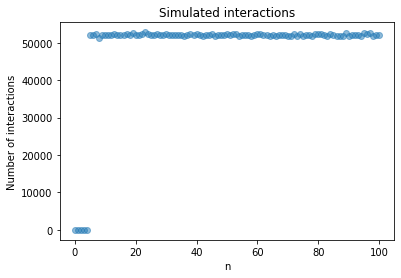

In [4]:
plt.scatter(n_list, n_sim_list, alpha=0.5)
plt.title('Simulated interactions')
plt.xlabel('n')
plt.ylabel('Number of interactions')
plt.show()

Run the cell below to create a plots with the total numbers of simulated significant interactions for each n. Both plots show the same data. The top one is a scatterplot and the bottom one is a line plot. The line plot makes the periodic fluctuations better visible.

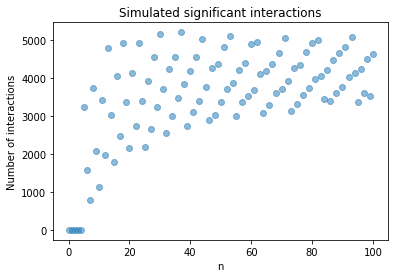

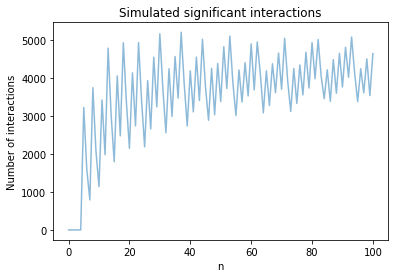

In [5]:
# Scatterplot
plt.scatter(n_list, n_sig_list, alpha=0.5)
plt.title('Simulated significant interactions')
plt.xlabel('n')
plt.ylabel('Number of interactions')
plt.show()
# Line plot
plt.plot(n_list, n_sig_list, alpha=0.5)
plt.title('Simulated significant interactions')
plt.xlabel('n')
plt.ylabel('Number of interactions')
plt.show()

Now we repeat the simulation for more realistic values for the P-value threshold and the maximum number of read pair counts per interaction.

In [6]:
p_value_cutoff=0.0019
bim_2 = BinomialInteractionModel(p_value_cutoff=p_value_cutoff)
n_max=400
i_num=20000000
n_list, n_sim_list, n_sig_list = bim_2.count_simulated_interactions(n_max=n_max, i_num=i_num)

[INFO] Looking for smallest number of read pairs n that yields a significant P-value with the threshold of 0.0019.
	[INFO] Smallest n: 10 read pairs (0.0009765625)
[INFO] Parameters
	[INFO] _out_prefix: OUTPREFIX
	[INFO] _p_value_cutoff: 0.0019
	[INFO] _n_indef: 10
	[INFO] _pv_indef: 0.0009765625
[INFO] Generating random numbers of simple and twisted read pairs ...
[INFO] Counting significant interactions for each n ...


Run the cell below to create a plot with the total numbers of simulated interactions for each n.

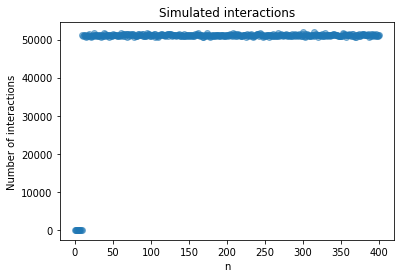

In [50]:
plt.scatter(n_list, n_sim_list, alpha=0.5)
plt.title('Simulated interactions')
plt.xlabel('n')
plt.ylabel('Number of interactions')
plt.show()

Run the cell below to create a plots with the total numbers of simulated significant interactions for each n.

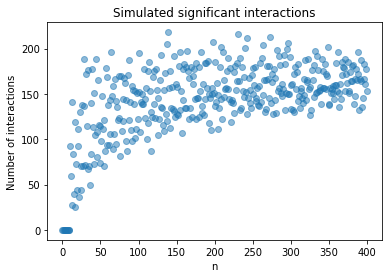

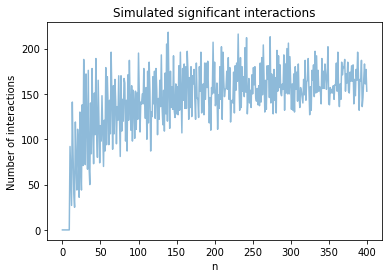

In [51]:
# Scatterplot
plt.scatter(n_list, n_sig_list, alpha=0.5)
plt.title('Simulated significant interactions')
plt.xlabel('n')
plt.ylabel('Number of interactions')
plt.show()
# Line plot
plt.plot(n_list, n_sig_list, alpha=0.5)
plt.title('Simulated significant interactions')
plt.xlabel('n')
plt.ylabel('Number of interactions')
plt.show()

## Comparison with empircal data

In [7]:
# This should be a diachromatic enhanced interaction file
iefile = '../results/06_select_reference_interactions/MK/MK_enhanced_interaction_file_with_di_and_uir.tsv.gz'
if not os.path.exists(iefile):
    raise FileNotFoundError("Could not find IE file")

In [8]:
n_def_list, n_sig_list = bim.count_significant_empirical_interactions(eifile=iefile)

... done.
... done.


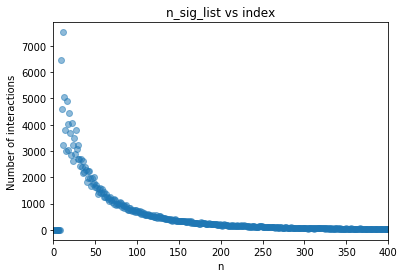

In [14]:
idx_list = list(range(0,len(n_sig_list)))

plt.scatter(idx_list, n_sig_list, alpha=0.5)
plt.title('n_sig_list vs index')
plt.xlabel('n')
plt.ylabel('Number of interactions')
plt.xlim(0,n_max)
plt.show()

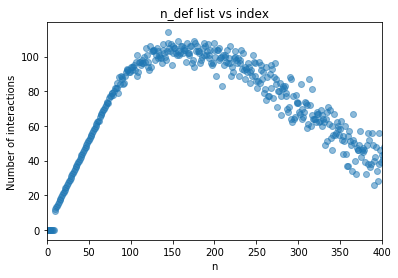

In [15]:
plt.scatter(idx_list, n_def_list, alpha=0.5)
plt.title('n_def list vs index')
plt.xlabel('n')
plt.ylabel('Number of interactions')
plt.xlim(0,n_max)
plt.show()